# Fitting Proteins

In [127]:

import parmed
from simtk.openmm import app
from simtk import unit
from oeommtools import utils as oeo_utils
from chemper.smirksify import SMIRKSifier
from chemper.graphs.cluster_graph import ClusterGraph

import copy
import random
import cmiles
import json



In [1]:
import os
import glob
import itertools
from chemper.chemper_utils import check_smirks_to_reference
from making_proteins import everything_from_fastas, print_order_type_data, at_least_one_passed
import cmiles
import json

In [2]:
help(check_smirks_to_reference)

Help on function check_smirks_to_reference in module chemper.chemper_utils:

check_smirks_to_reference(current_types, reference_assignments, molecules)
    Parameters
    ----------
    current_types: list of tuples
        SMIRKS types in the form (label, smirks)
    reference_assignments: dictionary of tuples and labels
        This could be the output from get_typed_molecules
        the dictionary has the form:
        {mol_idx: {(atom indices tuple): label}, mol_idx2: {} }
    molecules: list of molecules
        These can be OpenEye, RDKit, or ChemPer molecules
    
    Returns
    -------
    agree: boolean
        Returns True if the SMIRKS type the molecules in the same way
        as the reference assignments



In [3]:
# def convert_clusters_to_dict()

In [4]:
from openeye import oechem, oedepict
import IPython
from IPython.display import display, Image

alpha_list = [255, 51, 153, 117]
final_colors = list()

for a in alpha_list:
    for c in oechem.OEGetContrastColors():
        temp_c = c.CreateCopy()
        temp_c.SetA(a)
        final_colors.append(temp_c)

def depictMatch(mol, match=None, supH = True, idx_atoms=list(), width=500, height=200, fn=None,
               color1=oechem.OELightBlue, color2=oechem.OELightSalmon, include_bonds=True):
    
    atom_bond_set = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.GetIdx() in idx_atoms:
            atom_bond_set.AddAtom(atom)
            if not include_bonds:
                continue
            for bond in atom.GetBonds():
                nbr_atom = bond.GetNbr(atom)
                if (nbr_atom.GetIdx() in idx_atoms) and nbr_atom.GetIdx() > atom.GetIdx():
                    atom_bond_set.AddBond(bond)
    
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetAtomColorStyle(oedepict.OEAtomColorStyle_WhiteMonochrome)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    
    # Highlight indexed atoms
    hstyle = oedepict.OEHighlightStyle_Cogwheel
    hcolor = oechem.OEColor(color1)
    if not atom_bond_set.IsEmpty():
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, atom_bond_set)
    
    if match is not None:
        # Highlight whole match
        hstyle = oedepict.OEHighlightStyle_BallAndStick
        hcolor = oechem.OEColor(color2)
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, match)
    
    img = oedepict.OEImage(width, height)
    oedepict.OERenderMolecule(img,disp)
    
    if fn is not None:
        ext = oechem.OEGetFileExtension(fn)
        if oedepict.OEIsRegisteredImageFile(ext):
            ofs = oechem.oeofstream()
            if not ofs.open(fn):
                print("OE could not open file due to error %s" % fn)
                ofs.close()
            else:
                oedepict.OERenderMolecule(ofs, ext, disp)
                ofs.close()
        else:
            print("OE could not handle extension on %s" % fn)
    return img

# Load systems into openMM systems

Here is what I would like to track and my planned structure:

What information do we need:

* quantitative parameters:
    - with units and "full values"
    - rounded within 0.001? to identify when parameters should be treated the same
* atom indices which will translate into OEmols with `oeommtools`
    - by parameter type
* parmed/openmm systems to make the oemols

#### What is the best way to store this data?

How to store this data isn't necessarily obvious, but this is what I'm thinking right now:

Dictionaries by parameter type with the setup:

* keys: string of quantitative parameters rounded to assigned values with two sub dictionaries:
    - 'atom indices': dictioanry with form {mol_num/id: list of atom indice tuples}
        * I think it makes more sense to keep these as dictionaries for now so that we can also have a {mol_num/id: molecule} dictionary that can be translated into the chemper format later
    - 'parameters': set of tuples so that if there are differences in rounding to the top string we can track them down and so we can store the units that go with each component

Separate dictionary with the molecules stored with the form `{mol_num/id: { 'oemol': oemol, 'parmed': parmed_system} }`. I think for a first pass it is worth storing both objects just in case, but ultimately we only really need to the oemol after the first set of dictionaries is done.

# Make fasta files

In [5]:
singles = ['G', 'A', 'V', 'L', 'I', 'M', 'F', 'W', 'P', 'S', 'T', 'C', 'Y', 'N', 'Q', 'D', 'E', 'K', 'R', 'H']

# EXAMPLE using fasta works for one dipeptide

Now I need to automate looping over single amino acid codes to make a full set of molecules

In [6]:
def make_di_fasta_file(pair, directory):
    p1, p2 = pair
    fasta_str = """>%s%s
%s%s
""" % (p1, p2, p1, p2)
    fn = '%s/%s_%s.fasta' % (directory, p1,p2)
    
    f = open(fn,'w')
    f.write(fasta_str)
    f.close()

In [34]:
def mol_to_idx_smi(m):
    for a in m.GetAtoms():
        a.SetMapIdx(a.GetIdx() + 1)
    return oechem.OEMolToSmiles(m)

def clusters_to_json(mols, clusters, smirs_order_types, json_file_name):
    param_keys = set([param for order, p_dict in smirks_order_dict.items() for param in p_dict.keys()])
    
    order_data = dict()
    for types, smirksifier_dict in smirs_order_types.items():
        order_data[types] = dict()
        for param_type, smirksifier in smirksifier_dict.items():
            order_data[types][param_type] = {
                'checked': smirksifier.checks,
                'type_list': smirksifier.current_smirks
            }
            
    new_clusters = dict()
    for param, c_list in clusters.items():
        if param not in param_keys:
            continue
            
        new_clusters[param] = list()
        for lab, list_by_mol in c_list:
            temp_mol_list = list()
            for mol_atoms in list_by_mol:
                temp_mol_list.append([tuple([i+1 for i in a]) for a in mol_atoms] )
            new_clusters[param].append((lab, temp_mol_list))
    
    toJ = {
        'smiles': [mol_to_idx_smi(m) for m in mols],
        'clusters': new_clusters,
        'smirks_lists': order_data
    }
    
    with open(json_file_name, 'w') as output:
        json.dump(toJ, output)
        
    return toJ

# Organize all of this into one/a few functions so that you can easily call the whole thing

In [54]:
directory = os.path.abspath("./mol_files/")
for p in itertools.combinations(singles, 2):
    make_di_fasta_file(p,directory)

In [ ]:
cwd = os.getcwd()
fastas = glob.glob('%s/mol_files/*.fasta' % cwd)
names = ['shuffle','biggest_size', 'most_mols', 'big_smirks']

xmls = [
    ('14all', 'amber14-all.xml'),
    ('99sbildn', 'amber99sbildn.xml')
]

for xml_label, protein_xml in xmls:
    all_params = ['improper_torsion', 'bond', 'proper_torsion', 'charge', 'angle', 'lj']
    
    for p in all_params:
        print(p,protein_xml)
        include_params = [p]
        n = 1
        prev_data_store, prev_smirs_order_types, \
        prev_mols, prev_clusters = everything_from_fastas(fastas[-n:], verbose=False, order_type_names=names,
                                                          protein_xml=protein_xml, include_params=include_params)
        passed = at_least_one_passed(prev_smirs_order_types)
        
        while passed and n < len(fastas):
            n += 1
            curr_data_store, curr_smirs_order_types, \
            curr_mols, curr_clusters = everything_from_fastas(fastas[-n:], verbose=False, order_type_names=names,
                                                              protein_xml=protein_xml, include_params=include_params)
            passed = at_least_one_passed(curr_smirs_order_types)
            
            if passed:
                prev_data_store = curr_data_store
                prev_smirs_order_types = curr_smirs_order_types
                prev_mols = curr_mols
                prev_clusters = curr_clusters
        
        if not passed:
            json_file = '%s_%s_%imols.json' % (xml_label, p, n-1)
            clusters_to_json(prev_mols, prev_clusters, prev_smirs_order_types, json_file)
            
        json_file = '%s_%s_%imols.json' % (xml_label, p, n)
        clusters_to_json(curr_mols, curr_clusters, curr_smirs_order_types, json_file)
        
    _, smirs_order_types, mols, clusters = everything_from_fastas(fastas, verbose=False,
                                                                  order_type_names = names, 
                                                                  protein_xml = protein_xml)
    json_file = '%s_all_%imols.json' % (xml_label, len(fastas))
    clusters_to_json(mols, clusters, smirs_order_types, json_file)
            

improper_torsion amber14-all.xml
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_s

most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
bigge

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
most_mols
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
big_smirks
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
shuffle
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
              

shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big

most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
bigge

most_mols
big_smirks
shuffle
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
biggest_size
most_mols
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
big_smirks
shuffle
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
biggest_size
most_mols
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of laye

most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
biggest_size
most_mols
big_smirks
shuffle
bigge

# ==================================================

# storing systems in Json files and writing converters

In [35]:
toJ = clusters_to_json(mols2, clusters2, smirs_order_types2, 
                       '/Users/caitlinbannan/Desktop/test_store_smirksifier.json')

# ==================================================

# Reparsing json system

In [37]:
def convert_json(json_file):
    with open(json_file, 'r') as inputf:
        new_d = json.load(inputf)    
    
    def make_mol(smiles):
        m = oechem.OEMol()
        oechem.OESmilesToMol(m,smiles)
        return m

    new_mols = [make_mol(s) for s in new_d['smiles']]
    new_maps = [cmiles.utils.get_atom_map(m, new_d['smiles'][m_idx]) for m_idx, m in enumerate(new_mols)]

    new_clusters = dict()

    for param, c_list in new_d['clusters'].items():
        new_clusters[param] = list()
        for label, list_by_mol in c_list:
            temp_mol_list = list()
            for m_idx, mol_atoms in enumerate(list_by_mol):
                temp_mol_list.append([tuple([new_maps[m_idx][i] for i in a]) for a in mol_atoms] )
            new_clusters[param].append((label, temp_mol_list))

    return new_mols, new_clusters, new_d['smirks_lists']


In [38]:
mols, clusters, smirks_order_dict = convert_json('/Users/caitlinbannan/Desktop/test_store_smirksifier.json')

CSS took 9.894371032714844e-05 seconds
Match SMILES: [H:19][c:7]1[c:9]([c:11]([c:10]([c:8]([c:6]1[C:5]([H:17])([H:18])[C@@:2]([H:16])([C:3](=[O:4])[N:24]([H:34])[C@:25]([H:35])([C:26](=[O:27])[O-:33])[C:28]([H:36])([H:37])[C:29]([H:38])([H:39])[C:30](=[O:31])[N:32]([H:40])[H:41])[N+:1]([H:13])([H:14])[H:15])[H:20])[H:22])[O:12][H:23])[H:21]
CSS took 0.0001220703125 seconds
Match SMILES: [H:19][c:7]1[c:9]([c:11]([c:10]([c:8]([c:6]1[C:5]([H:17])([H:18])[C@@:2]([H:16])([C:3](=[O:4])[N:24]([H:36])[C@:25]([H:37])([C:26](=[O:27])[O-:35])[C:28]([H:38])([H:39])[C:29]([H:40])([H:41])[C:30]([H:42])([H:43])[N:31]([H:44])[C:32](=[N+:33]([H:45])[H:46])[N:34]([H:47])[H:48])[N+:1]([H:13])([H:14])[H:15])[H:20])[H:22])[O:12][H:23])[H:21]


In [39]:
clusters

{'charge': [('0.03710', [[], [(22,), (23,)]]),
  ('-0.82660', [[], [(19,), (20,)]]),
  ('0.77750', [[(18,)], []]),
  ('0.14470', [[], [(17,)]]),
  ('0.31390', [[(3,)], [(3,)]]),
  ('0.61230', [[(12,)], [(12,)]]),
  ('-0.60980', [[(28,)], []]),
  ('0.04680', [[], [(28,), (29,)]]),
  ('0.06590', [[(7,)], [(7,)]]),
  ('0.16500', [[(40,), (37,)], [(47,), (44,)]]),
  ('-0.87370', [[], [(33,), (36,)]]),
  ('0.26810', [[(15,)], []]),
  ('0.12320', [[(17,)], []]),
  ('-0.02100', [[(24,)], []]),
  ('-0.38210', [[(14,)], []]),
  ('-0.95740', [[(29,)], []]),
  ('-0.34810', [[], [(14,)]]),
  ('0.07440', [[], [(24,)]]),
  ('0.34790', [[], [(31,)]]),
  ('0.83680', [[], [(32,)]]),
  ('-0.02050', [[(6,)], [(6,)]]),
  ('0.27640', [[], [(15,)]]),
  ('0.43040', [[(30,), (31,)], []]),
  ('0.02030', [[(25,), (26,)], []]),
  ('0.18730', [[(33,), (34,), (35,)], [(40,), (41,), (42,)]]),
  ('0.44930', [[], [(34,), (35,), (37,), (38,)]]),
  ('-0.20020', [[(1,), (5,)], [(1,), (5,)]]),
  ('-0.22390', [[(2,), (4,)

# Example for visualizing results

0.03710
--------------------------------------------------------------------------------
1 6


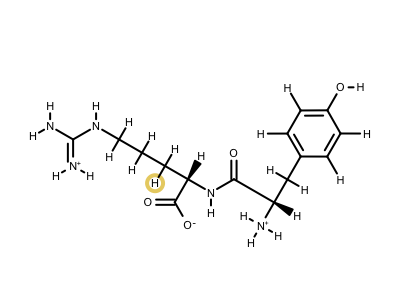

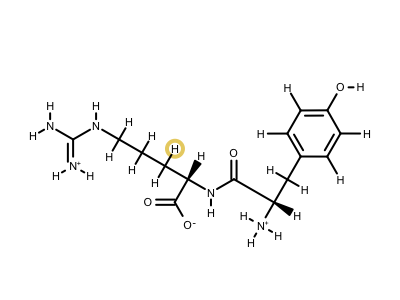

-0.82660
--------------------------------------------------------------------------------
1 6


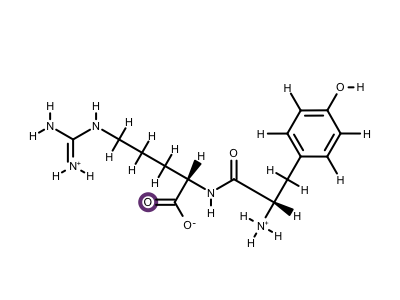

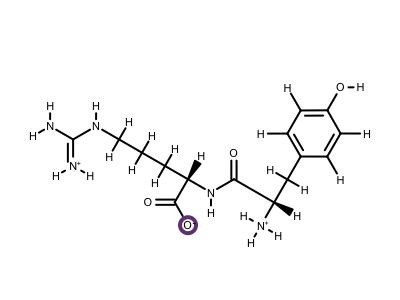

0.77750
--------------------------------------------------------------------------------
0 6


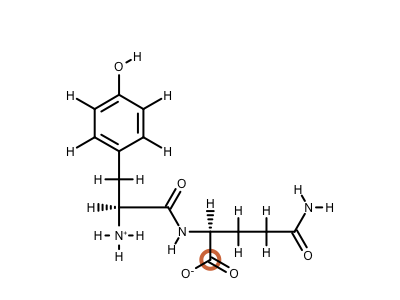

0.14470
--------------------------------------------------------------------------------
1 6


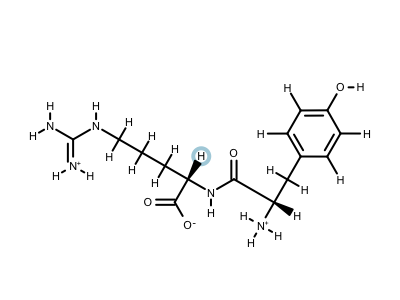

0.31390
--------------------------------------------------------------------------------
0 6


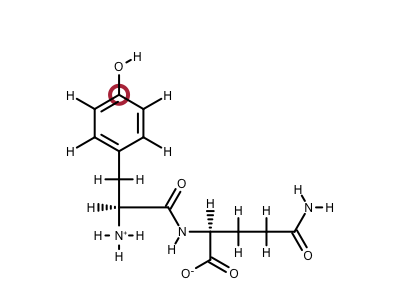

--------------------------------------------------------------------------------
1 6


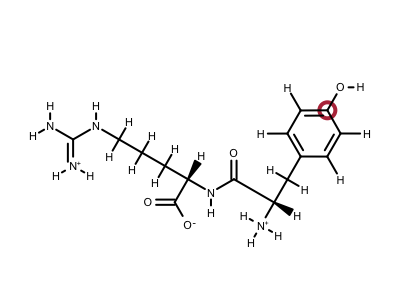

0.61230
--------------------------------------------------------------------------------
0 6


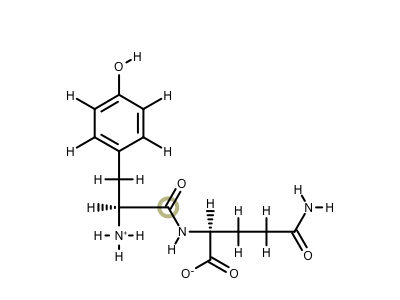

--------------------------------------------------------------------------------
1 6


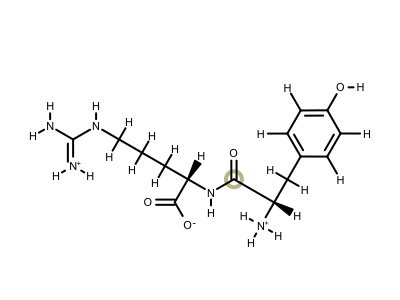

-0.60980
--------------------------------------------------------------------------------
0 6


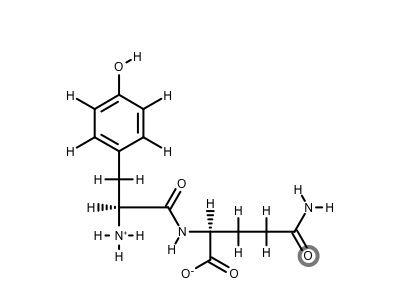

0.04680
--------------------------------------------------------------------------------
1 6


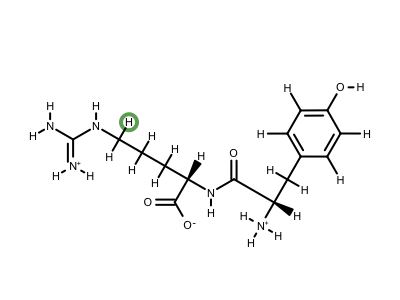

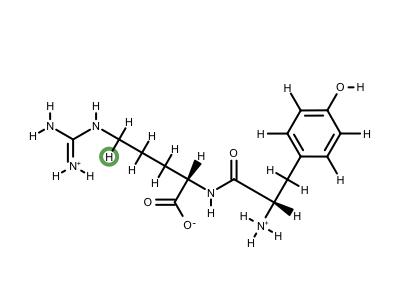

0.06590
--------------------------------------------------------------------------------
0 6


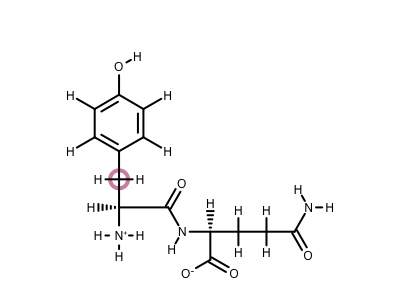

--------------------------------------------------------------------------------
1 6


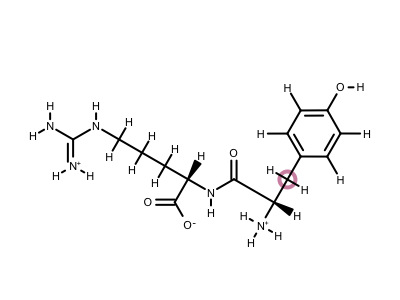

0.16500
--------------------------------------------------------------------------------
0 6


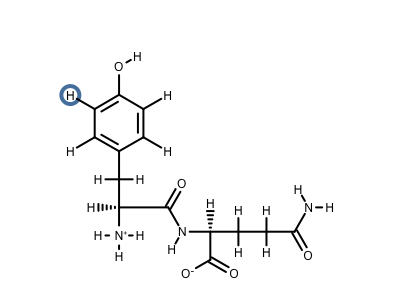

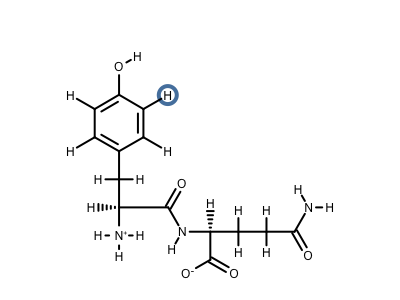

--------------------------------------------------------------------------------
1 6


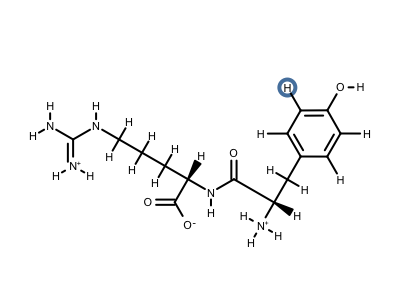

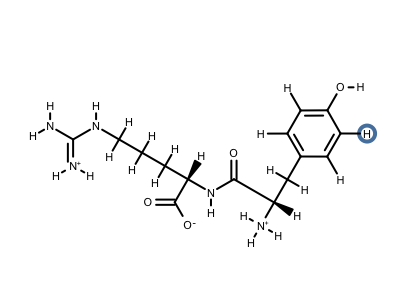

-0.87370
--------------------------------------------------------------------------------
1 6


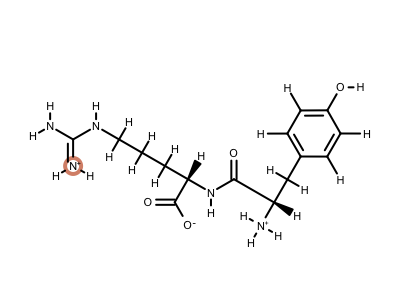

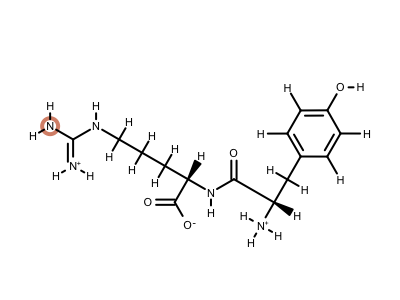

0.26810
--------------------------------------------------------------------------------
0 6


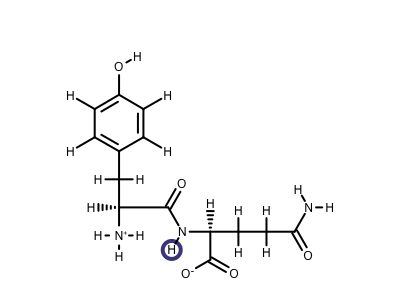

0.12320
--------------------------------------------------------------------------------
0 6


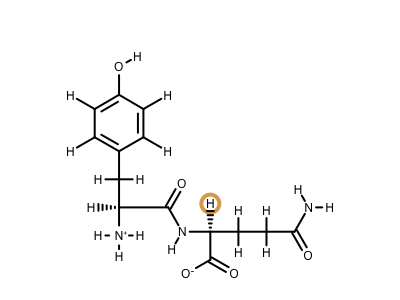

-0.02100
--------------------------------------------------------------------------------
0 6


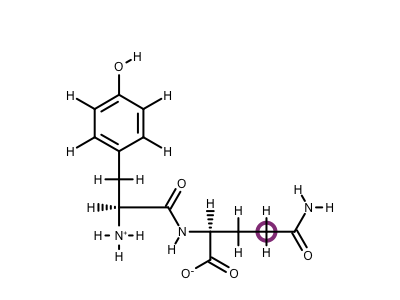

-0.38210
--------------------------------------------------------------------------------
0 6


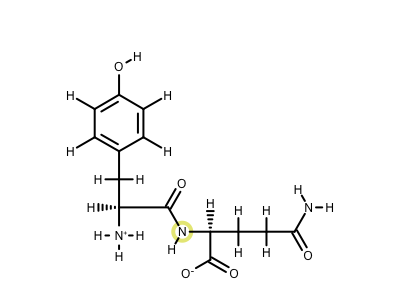

-0.95740
--------------------------------------------------------------------------------
0 6


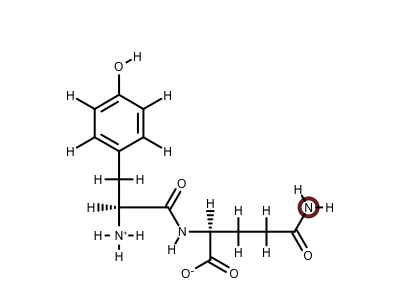

-0.34810
--------------------------------------------------------------------------------
1 6


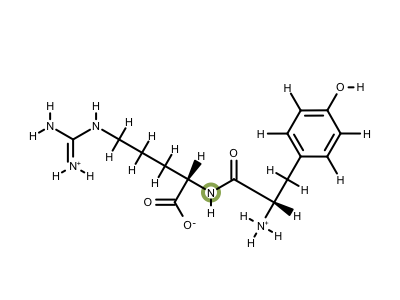

0.07440
--------------------------------------------------------------------------------
1 6


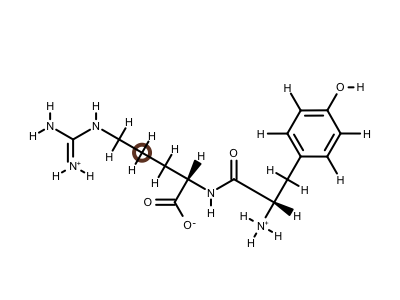

0.34790
--------------------------------------------------------------------------------
1 6


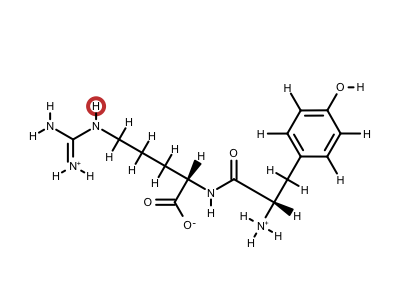

0.83680
--------------------------------------------------------------------------------
1 6


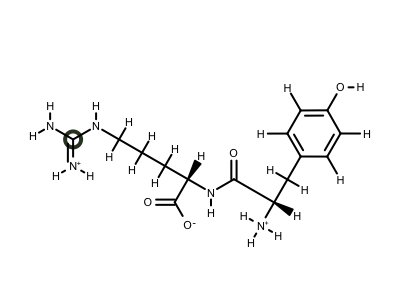

-0.02050
--------------------------------------------------------------------------------
0 6


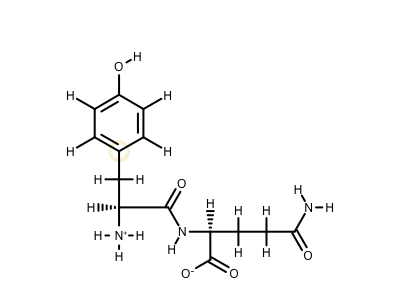

--------------------------------------------------------------------------------
1 6


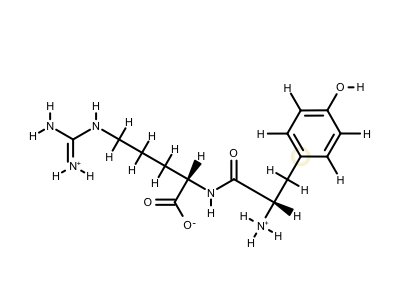

0.27640
--------------------------------------------------------------------------------
1 6


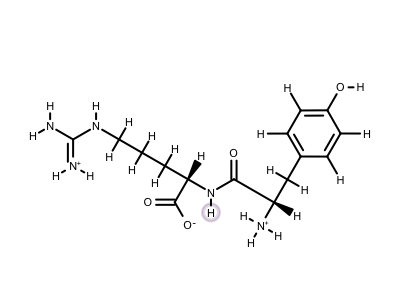

0.43040
--------------------------------------------------------------------------------
0 6


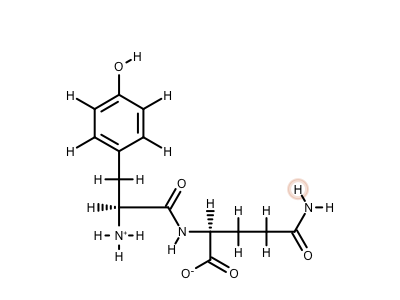

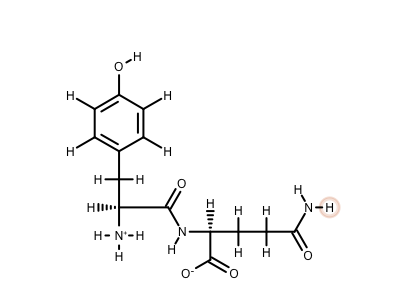

0.02030
--------------------------------------------------------------------------------
0 6


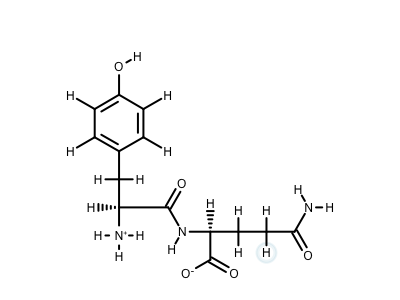

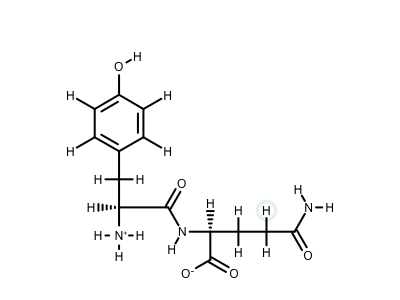

0.18730
--------------------------------------------------------------------------------
0 6


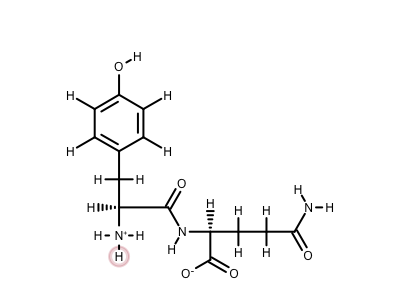

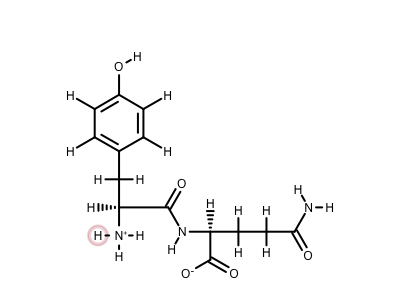

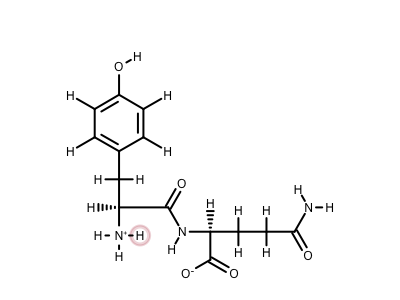

--------------------------------------------------------------------------------
1 6


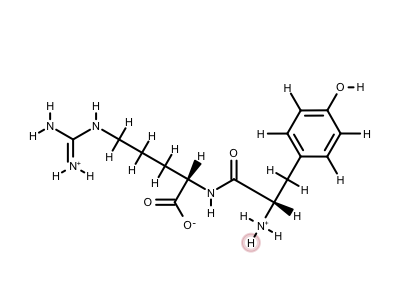

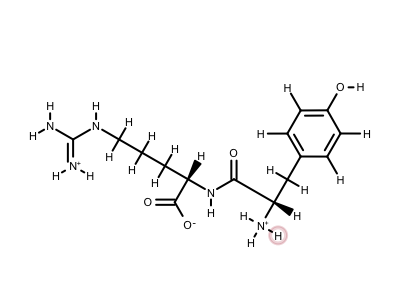

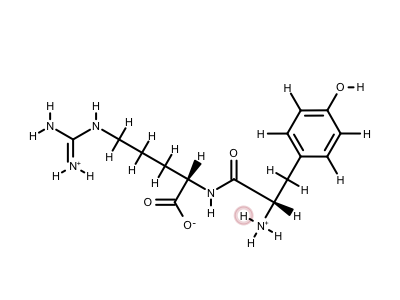

0.44930
--------------------------------------------------------------------------------
1 6


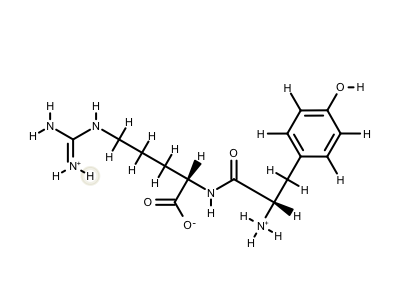

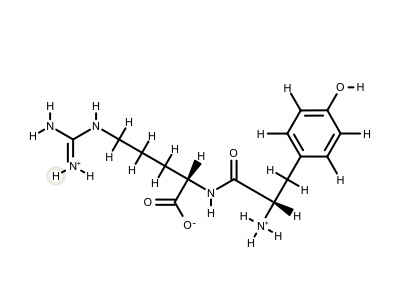

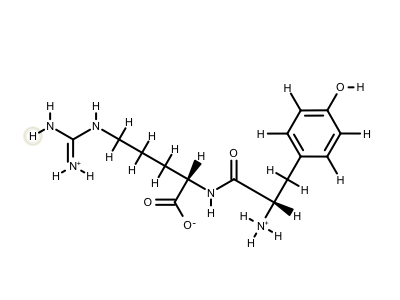

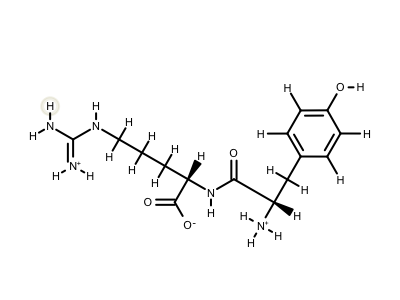

-0.20020
--------------------------------------------------------------------------------
0 6


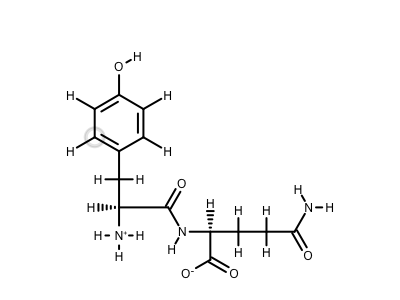

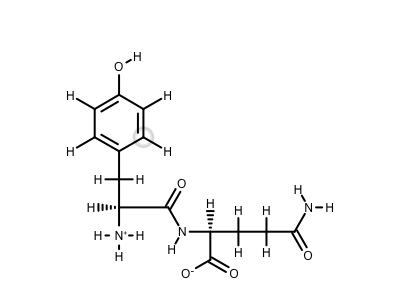

--------------------------------------------------------------------------------
1 6


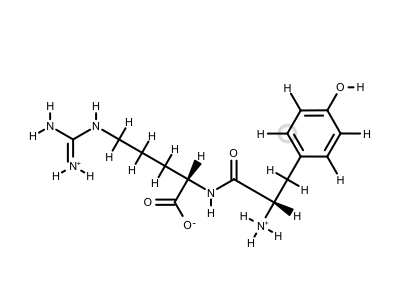

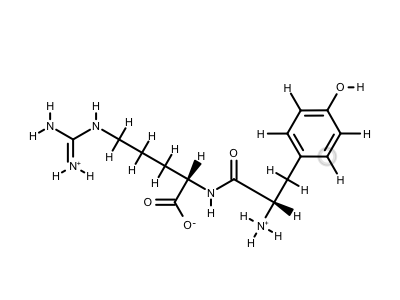

-0.22390
--------------------------------------------------------------------------------
0 6


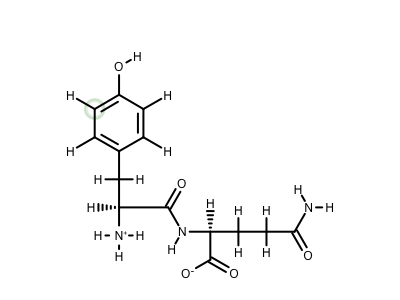

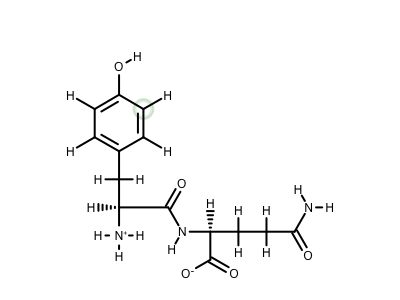

--------------------------------------------------------------------------------
1 6


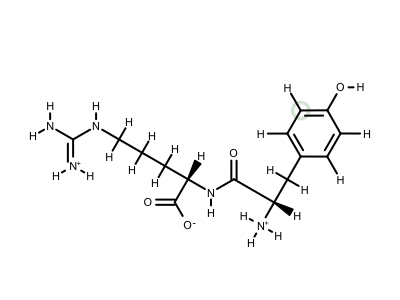

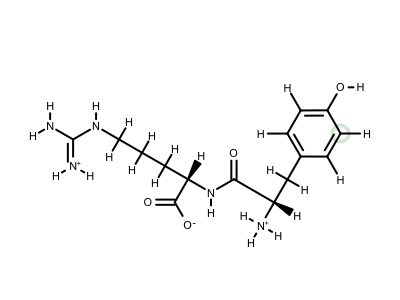

0.11140
--------------------------------------------------------------------------------
1 6


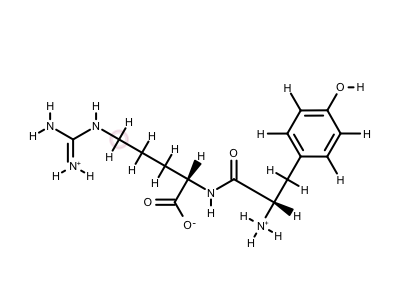

-0.80420
--------------------------------------------------------------------------------
0 6


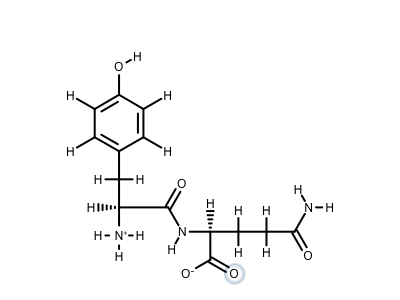

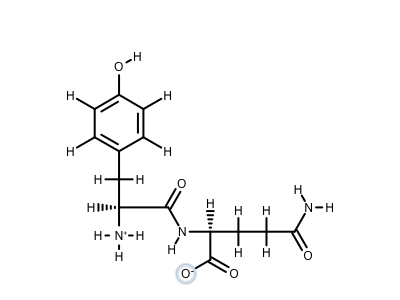

-0.03740
--------------------------------------------------------------------------------
1 6


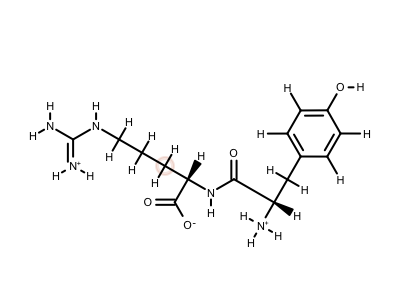

0.09830
--------------------------------------------------------------------------------
0 6


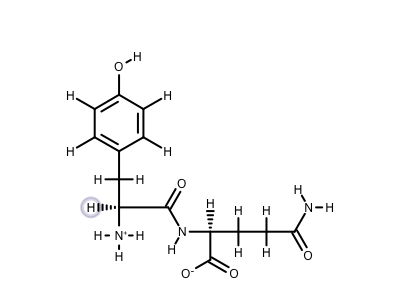

--------------------------------------------------------------------------------
1 6


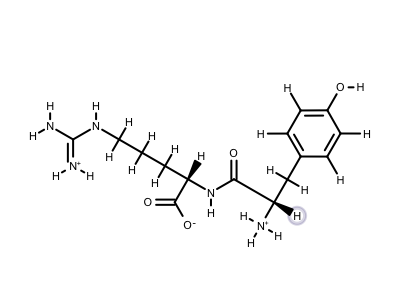

-0.55640
--------------------------------------------------------------------------------
1 6


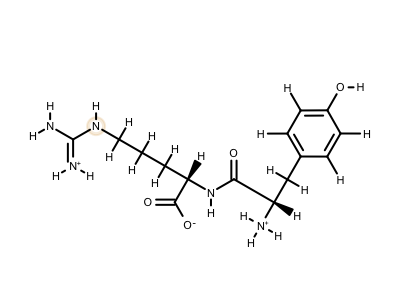

-0.57130
--------------------------------------------------------------------------------
0 6


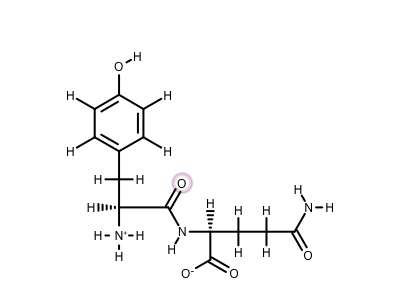

--------------------------------------------------------------------------------
1 6


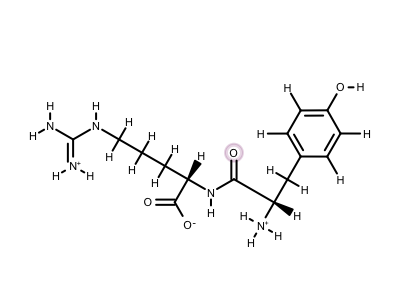

0.01020
--------------------------------------------------------------------------------
0 6


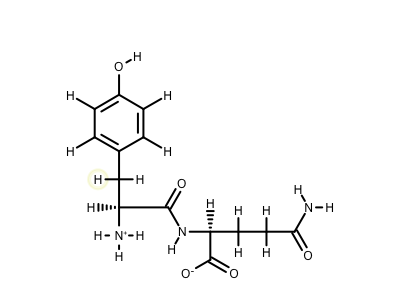

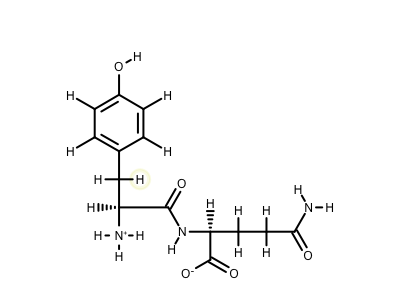

--------------------------------------------------------------------------------
1 6


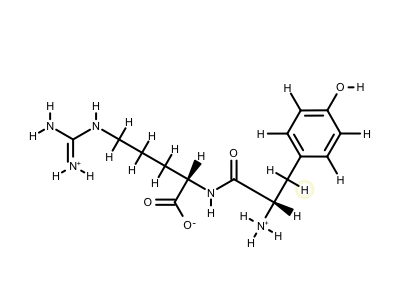

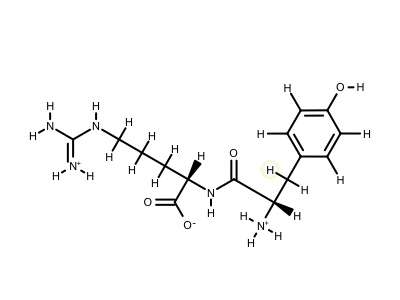

0.04520
--------------------------------------------------------------------------------
0 6


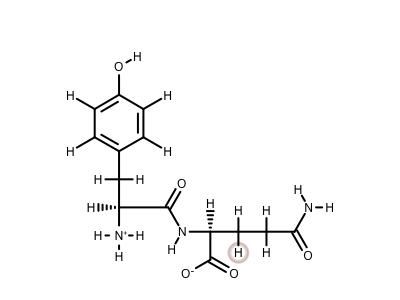

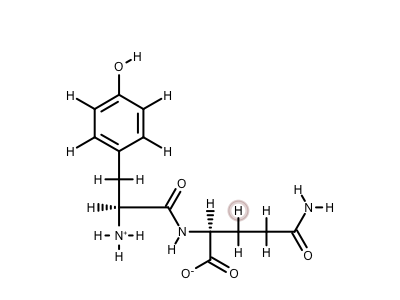

0.70930
--------------------------------------------------------------------------------
0 6


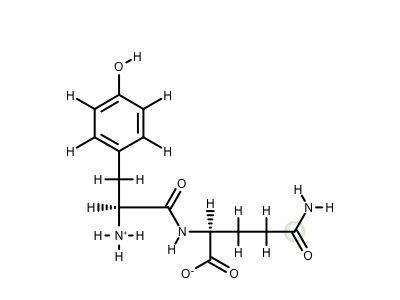

0.40010
--------------------------------------------------------------------------------
0 6


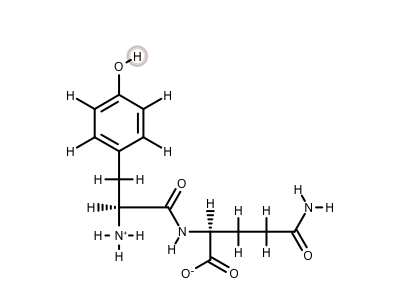

--------------------------------------------------------------------------------
1 6


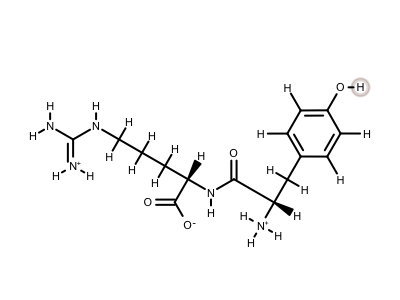

0.85570
--------------------------------------------------------------------------------
1 6


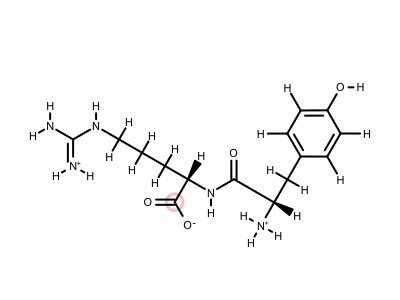

-0.22480
--------------------------------------------------------------------------------
0 6


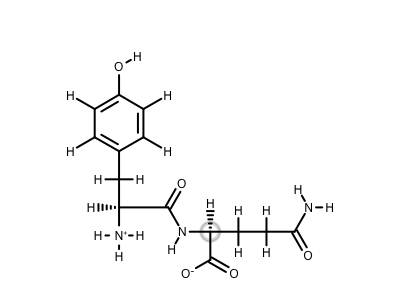

-0.06640
--------------------------------------------------------------------------------
0 6


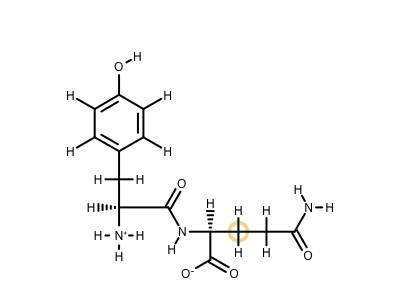

0.05700
--------------------------------------------------------------------------------
0 6


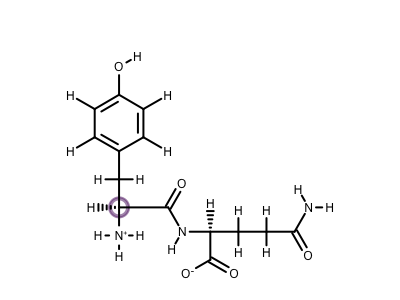

--------------------------------------------------------------------------------
1 6


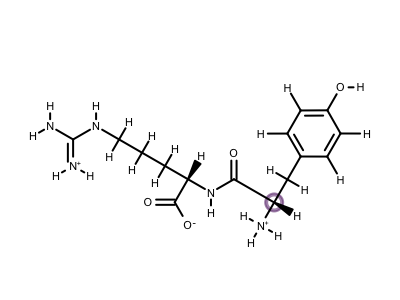

0.17200
--------------------------------------------------------------------------------
0 6


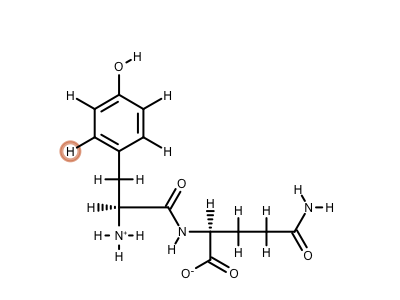

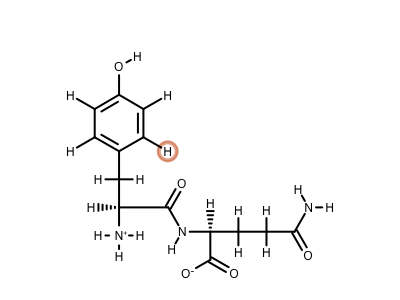

--------------------------------------------------------------------------------
1 6


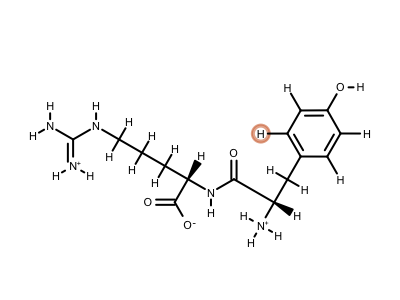

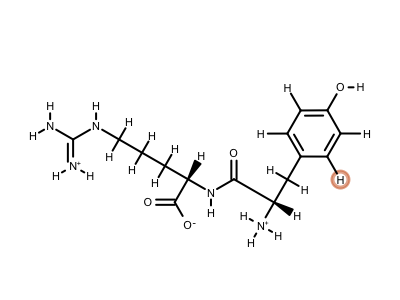

-0.55780
--------------------------------------------------------------------------------
0 6


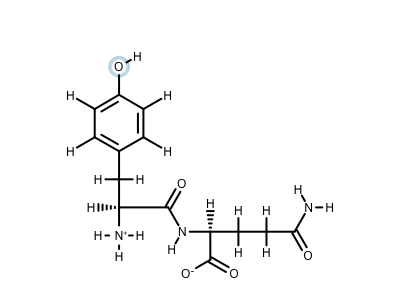

--------------------------------------------------------------------------------
1 6


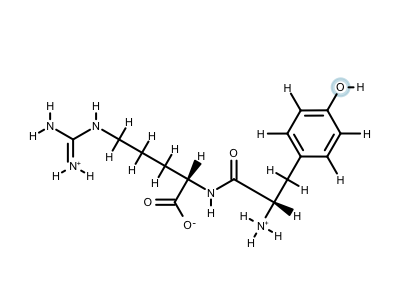

0.19400
--------------------------------------------------------------------------------
0 6


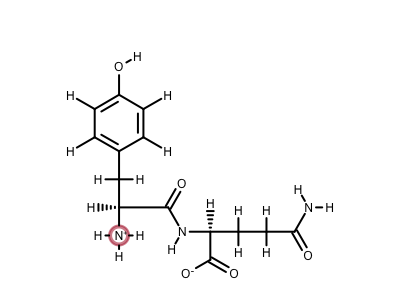

--------------------------------------------------------------------------------
1 6


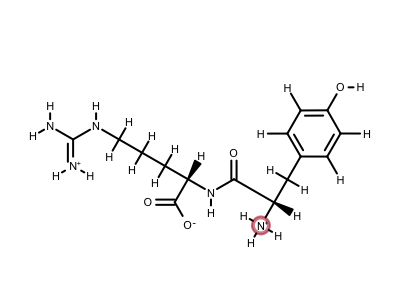

0.01850
--------------------------------------------------------------------------------
1 6


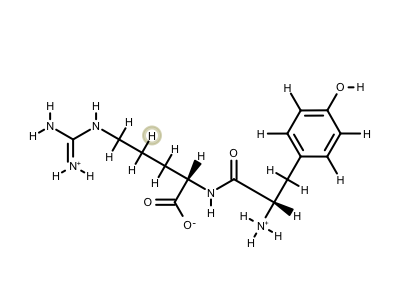

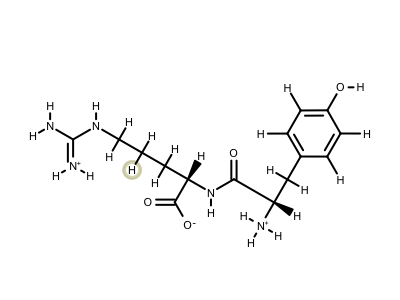

-0.30680
--------------------------------------------------------------------------------
1 6


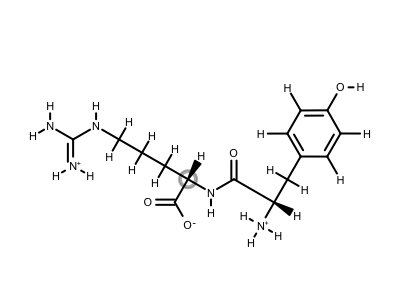

In [41]:
for c_idx, (p_lab, cluster) in enumerate(clusters['charge']):
    print(p_lab)
    color = final_colors[c_idx]
    for mol_idx, atom_indice_list in enumerate(cluster):
        if len(atom_indice_list) == 0:
            continue
        print('-'*80)
        m = oechem.OEMol(mols[mol_idx])
        aros = [atom for atom in m.GetAtoms() if atom.IsAromatic()]
        print(mol_idx, oechem.OECount(m, oechem.OEIsAromaticAtom())) 
            
        
        #m.SetTitle(p_lab)
        for a_idx, a in enumerate(atom_indice_list):
            img = depictMatch(m, supH=False, idx_atoms=a, color1=color, width=400, height=300)
            display(Image(oedepict.OEWriteImageToString("png",img)))